# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [262]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [263]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [264]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [170]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x*x), 3*x*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

[3.]
Gradient check passed!
[3. 2.]
[3. 2.]
Gradient check passed!
[[3. 2.]
 [1. 0.]]
[[3. 2.]
 [1. 0.]]
[[3. 2.]
 [1. 0.]]
[[3. 2.]
 [1. 0.]]
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [169]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [13]:
probs = linear_classifer.softmax(np.array([1, 0, 0]))
linear_classifer.cross_entropy_loss(probs, 1)

1.551444713932051

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [14]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [241]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 2
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

[[-1.  0.]]
[[-1.  0.]]
Gradient check passed!
[[ 0.  2.  2.  1.]
 [ 2.  1.  2. -1.]
 [ 2.  1.  1.  0.]]
[[ 0.  2.  2.  1.]
 [ 2.  1.  2. -1.]
 [ 2.  1.  1.  0.]]
[[ 0.  2.  2.  1.]
 [ 2.  1.  2. -1.]
 [ 2.  1.  1.  0.]]
[[ 0.  2.  2.  1.]
 [ 2.  1.  2. -1.]
 [ 2.  1.  1.  0.]]
[[ 0.  2.  2.  1.]
 [ 2.  1.  2. -1.]
 [ 2.  1.  1.  0.]]
[[ 0.  2.  2.  1.]
 [ 2.  1.  2. -1.]
 [ 2.  1.  1.  0.]]
[[ 0.  2.  2.  1.]
 [ 2.  1.  2. -1.]
 [ 2.  1.  1.  0.]]
[[ 0.  2.  2.  1.]
 [ 2.  1.  2. -1.]
 [ 2.  1.  1.  0.]]
[[ 0.  2.  2.  1.]
 [ 2.  1.  2. -1.]
 [ 2.  1.  1.  0.]]
[[ 0.  2.  2.  1.]
 [ 2.  1.  2. -1.]
 [ 2.  1.  1.  0.]]
[[ 0.  2.  2.  1.]
 [ 2.  1.  2. -1.]
 [ 2.  1.  1.  0.]]
[[ 0.  2.  2.  1.]
 [ 2.  1.  2. -1.]
 [ 2.  1.  1.  0.]]
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [249]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)
`
loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [254]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [294]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 24922.369572
Epoch 1, loss: 27568.257028
Epoch 2, loss: 25915.370534
Epoch 3, loss: 25485.690955
Epoch 4, loss: 26419.512496
Epoch 5, loss: 26549.373371
Epoch 6, loss: 25401.388208
Epoch 7, loss: 27931.257945
Epoch 8, loss: 25479.705492
Epoch 9, loss: 27469.742426


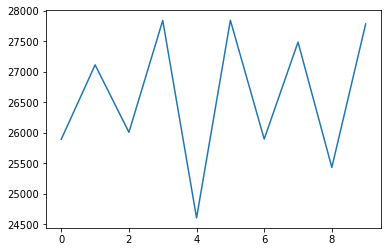

In [293]:
# let's look at the loss history!
plt.plot(loss_history)

In [299]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.133
Epoch 0, loss: 25978.411762
Epoch 1, loss: 27381.633479
Epoch 2, loss: 26266.139362
Epoch 3, loss: 26511.701239
Epoch 4, loss: 26470.962245
Epoch 5, loss: 25424.576244
Epoch 6, loss: 28634.990773
Epoch 7, loss: 26213.566567
Epoch 8, loss: 27093.455477
Epoch 9, loss: 26834.162172
Epoch 10, loss: 26454.338859
Epoch 11, loss: 25437.447439
Epoch 12, loss: 26607.349671
Epoch 13, loss: 26649.102200
Epoch 14, loss: 26118.862303
Epoch 15, loss: 25956.558123
Epoch 16, loss: 25944.224290
Epoch 17, loss: 26986.347475
Epoch 18, loss: 26939.865937
Epoch 19, loss: 26317.581044
Epoch 20, loss: 26442.674224
Epoch 21, loss: 25094.637598
Epoch 22, loss: 26185.744503
Epoch 23, loss: 26573.473301
Epoch 24, loss: 25448.345896
Epoch 25, loss: 26575.668666
Epoch 26, loss: 25837.265487
Epoch 27, loss: 26470.927110
Epoch 28, loss: 25756.586727
Epoch 29, loss: 27152.838015
Epoch 30, loss: 26472.760036
Epoch 31, loss: 26197.815815
Epoch 32, loss: 28035.603736
Epoch 33, loss: 26864.896440
Epoch 3

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [309]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

best = []

for lr in learning_rates:
    for reg in reg_strengths:
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=reg)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        best.append([classifier, accuracy])
        
best.sort(key=lambda x: x[1], reverse=True)
best_classifier = best[0][0]
best_val_accuracy = best[0][1]

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 23052.014226
Epoch 1, loss: 20490.188903
Epoch 2, loss: 21865.312162
Epoch 3, loss: 20713.859037
Epoch 4, loss: 21237.579629
Epoch 5, loss: 22227.257348
Epoch 6, loss: 20183.110101
Epoch 7, loss: 20922.269372
Epoch 8, loss: 21888.141109
Epoch 9, loss: 19968.801980
Epoch 10, loss: 21279.017265
Epoch 11, loss: 21500.608902
Epoch 12, loss: 20735.518011
Epoch 13, loss: 20278.927904
Epoch 14, loss: 20314.923282
Epoch 15, loss: 20040.293554
Epoch 16, loss: 21453.174382
Epoch 17, loss: 20126.207701
Epoch 18, loss: 19926.232867
Epoch 19, loss: 21079.937196
Epoch 20, loss: 18620.887066
Epoch 21, loss: 21529.372866
Epoch 22, loss: 20047.843790
Epoch 23, loss: 19515.034390
Epoch 24, loss: 18834.875902
Epoch 25, loss: 21704.734539
Epoch 26, loss: 20921.484789
Epoch 27, loss: 20089.402513
Epoch 28, loss: 21237.589217
Epoch 29, loss: 21013.232230
Epoch 30, loss: 20724.044198
Epoch 31, loss: 20964.822208
Epoch 32, loss: 20507.890050
Epoch 33, loss: 20019.477063
Epoch 34, loss: 20090.37

Epoch 80, loss: 19343.302752
Epoch 81, loss: 20561.063910
Epoch 82, loss: 20112.521290
Epoch 83, loss: 20126.519581
Epoch 84, loss: 19995.031750
Epoch 85, loss: 20048.822051
Epoch 86, loss: 20961.311141
Epoch 87, loss: 20192.550032
Epoch 88, loss: 20376.786759
Epoch 89, loss: 21883.025866
Epoch 90, loss: 18929.984960
Epoch 91, loss: 19537.777207
Epoch 92, loss: 20209.803771
Epoch 93, loss: 19850.770847
Epoch 94, loss: 20806.059704
Epoch 95, loss: 19853.331797
Epoch 96, loss: 19177.782759
Epoch 97, loss: 19255.504450
Epoch 98, loss: 19879.700106
Epoch 99, loss: 19988.219608
Epoch 100, loss: 20078.978781
Epoch 101, loss: 21144.801134
Epoch 102, loss: 20299.741113
Epoch 103, loss: 20659.120497
Epoch 104, loss: 19984.083475
Epoch 105, loss: 21350.585428
Epoch 106, loss: 19497.423760
Epoch 107, loss: 20055.151832
Epoch 108, loss: 20537.070440
Epoch 109, loss: 19152.463097
Epoch 110, loss: 21520.021497
Epoch 111, loss: 20723.020548
Epoch 112, loss: 20507.144309
Epoch 113, loss: 20032.353623


Epoch 158, loss: 20577.354144
Epoch 159, loss: 19804.863549
Epoch 160, loss: 19340.194643
Epoch 161, loss: 18914.925391
Epoch 162, loss: 19088.964533
Epoch 163, loss: 22233.875207
Epoch 164, loss: 19093.386423
Epoch 165, loss: 20309.660825
Epoch 166, loss: 19924.365366
Epoch 167, loss: 19754.558140
Epoch 168, loss: 19077.867890
Epoch 169, loss: 19490.499083
Epoch 170, loss: 19933.142048
Epoch 171, loss: 19594.178914
Epoch 172, loss: 19055.576036
Epoch 173, loss: 20053.612297
Epoch 174, loss: 19992.243747
Epoch 175, loss: 20299.471251
Epoch 176, loss: 20393.005116
Epoch 177, loss: 19080.644252
Epoch 178, loss: 19135.839432
Epoch 179, loss: 19702.584562
Epoch 180, loss: 18731.090820
Epoch 181, loss: 20081.762331
Epoch 182, loss: 20020.449657
Epoch 183, loss: 19324.794281
Epoch 184, loss: 20722.692710
Epoch 185, loss: 20003.350826
Epoch 186, loss: 18793.295079
Epoch 187, loss: 20542.844286
Epoch 188, loss: 19097.544010
Epoch 189, loss: 20028.231569
Epoch 190, loss: 20158.184265
Epoch 191,

Epoch 37, loss: 15835.210204
Epoch 38, loss: 15834.908388
Epoch 39, loss: 15837.734057
Epoch 40, loss: 15838.086335
Epoch 41, loss: 15839.119359
Epoch 42, loss: 15828.424984
Epoch 43, loss: 15838.473245
Epoch 44, loss: 15835.293028
Epoch 45, loss: 15839.973851
Epoch 46, loss: 15832.923420
Epoch 47, loss: 15833.928232
Epoch 48, loss: 15835.906552
Epoch 49, loss: 15834.957783
Epoch 50, loss: 15833.609985
Epoch 51, loss: 15835.945809
Epoch 52, loss: 15835.161593
Epoch 53, loss: 15831.101589
Epoch 54, loss: 15829.110970
Epoch 55, loss: 15831.925047
Epoch 56, loss: 15829.323782
Epoch 57, loss: 15838.896432
Epoch 58, loss: 15838.012791
Epoch 59, loss: 15832.303179
Epoch 60, loss: 15829.733301
Epoch 61, loss: 15834.487586
Epoch 62, loss: 15832.017772
Epoch 63, loss: 15829.767625
Epoch 64, loss: 15834.739782
Epoch 65, loss: 15830.035104
Epoch 66, loss: 15830.769096
Epoch 67, loss: 15829.325711
Epoch 68, loss: 15829.722677
Epoch 69, loss: 15831.817771
Epoch 70, loss: 15828.329081
Epoch 71, loss

Epoch 116, loss: 15796.737077
Epoch 117, loss: 15797.067012
Epoch 118, loss: 15800.446384
Epoch 119, loss: 15800.214334
Epoch 120, loss: 15800.117062
Epoch 121, loss: 15799.912835
Epoch 122, loss: 15799.507045
Epoch 123, loss: 15793.520028
Epoch 124, loss: 15798.422691
Epoch 125, loss: 15801.010821
Epoch 126, loss: 15799.435213
Epoch 127, loss: 15795.325218
Epoch 128, loss: 15798.519865
Epoch 129, loss: 15798.204165
Epoch 130, loss: 15797.028999
Epoch 131, loss: 15801.453572
Epoch 132, loss: 15795.740256
Epoch 133, loss: 15800.168582
Epoch 134, loss: 15797.047738
Epoch 135, loss: 15798.740227
Epoch 136, loss: 15799.077353
Epoch 137, loss: 15796.731874
Epoch 138, loss: 15797.341880
Epoch 139, loss: 15799.902697
Epoch 140, loss: 15798.804224
Epoch 141, loss: 15801.461266
Epoch 142, loss: 15801.278833
Epoch 143, loss: 15793.627315
Epoch 144, loss: 15799.526113
Epoch 145, loss: 15796.370502
Epoch 146, loss: 15796.902238
Epoch 147, loss: 15803.963735
Epoch 148, loss: 15796.068526
Epoch 149,

Epoch 193, loss: 15773.073274
Epoch 194, loss: 15772.405301
Epoch 195, loss: 15772.829675
Epoch 196, loss: 15772.330094
Epoch 197, loss: 15772.701896
Epoch 198, loss: 15772.530415
Epoch 199, loss: 15772.634547
Epoch 0, loss: 15763.867294
Epoch 1, loss: 15763.861743
Epoch 2, loss: 15764.258726
Epoch 3, loss: 15764.087006
Epoch 4, loss: 15764.185243
Epoch 5, loss: 15764.023025
Epoch 6, loss: 15764.017931
Epoch 7, loss: 15764.197441
Epoch 8, loss: 15764.135849
Epoch 9, loss: 15764.308350
Epoch 10, loss: 15764.459564
Epoch 11, loss: 15763.774918
Epoch 12, loss: 15764.439473
Epoch 13, loss: 15763.655775
Epoch 14, loss: 15763.978193
Epoch 15, loss: 15763.660996
Epoch 16, loss: 15763.782117
Epoch 17, loss: 15764.238345
Epoch 18, loss: 15763.777702
Epoch 19, loss: 15763.885920
Epoch 20, loss: 15763.901720
Epoch 21, loss: 15764.040958
Epoch 22, loss: 15763.715308
Epoch 23, loss: 15763.842705
Epoch 24, loss: 15763.953604
Epoch 25, loss: 15763.825232
Epoch 26, loss: 15763.546664
Epoch 27, loss: 1

Epoch 73, loss: 15760.721794
Epoch 74, loss: 15760.430948
Epoch 75, loss: 15761.005070
Epoch 76, loss: 15760.716103
Epoch 77, loss: 15760.382490
Epoch 78, loss: 15760.826295
Epoch 79, loss: 15760.364428
Epoch 80, loss: 15760.480046
Epoch 81, loss: 15760.490389
Epoch 82, loss: 15760.416858
Epoch 83, loss: 15760.445607
Epoch 84, loss: 15760.676749
Epoch 85, loss: 15760.311533
Epoch 86, loss: 15760.143434
Epoch 87, loss: 15760.667555
Epoch 88, loss: 15760.650848
Epoch 89, loss: 15760.208885
Epoch 90, loss: 15760.361161
Epoch 91, loss: 15760.660448
Epoch 92, loss: 15760.656667
Epoch 93, loss: 15760.427102
Epoch 94, loss: 15760.524994
Epoch 95, loss: 15760.300144
Epoch 96, loss: 15760.809594
Epoch 97, loss: 15760.873090
Epoch 98, loss: 15760.443365
Epoch 99, loss: 15760.216747
Epoch 100, loss: 15760.326359
Epoch 101, loss: 15760.642794
Epoch 102, loss: 15760.192521
Epoch 103, loss: 15759.931638
Epoch 104, loss: 15759.989957
Epoch 105, loss: 15759.885318
Epoch 106, loss: 15760.286060
Epoch 1

In [310]:
best_classifier

# Какой же точности мы добились на тестовых данных?

In [311]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.189000
